In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.model_selection import train_test_split

sns.set()
random_state = 123_456
np.random.seed(random_state)

error_tolerance_percentage = 2.5
look_back = 7
batch_size = 8
COL_POS = 0

Using TensorFlow backend.


In [2]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [3]:
features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4']
# features = ['price']
df.shape

(1095, 10)

In [4]:
df = df[features]
df

price  tapis_oil_price_t_minus_10  wholesale_price_t_minus_4
2017-01-01   1417                        5863                       1183
2017-01-02   1436                        5863                       1183
2017-01-03   1409                        5863                       1183
2017-01-04   1542                        5863                       1183
2017-01-05   1582                        5863                       1183
...           ...                         ...                        ...
2019-12-27   1608                        7084                       1332
2019-12-28   1589                        7103                       1332
2019-12-29   1579                        7159                       1335
2019-12-30   1602                        7198                       1336
2019-12-31   1609                        7177                       1338

[1095 rows x 3 columns]

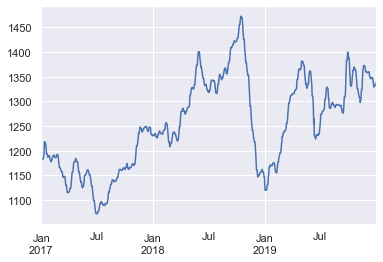

In [5]:
df.wholesale_price_t_minus_4.plot()

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
del df
df_train.shape

(985, 3)

In [7]:
df_test.shape

(110, 3)

In [8]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    TIME_STEPS = look_back + 1
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [9]:
# np.zeros(((10-8), 8, 1))
# df_train.values[0:8]

In [10]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [11]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [12]:
should_standard_scale = True

if should_standard_scale:
    ct = make_column_transformer((MinMaxScaler(), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='box-cox'), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='yeo-johnson'), features), verbose=True)

    result = ct.fit_transform(df_train)
    df_temp = pd.DataFrame(result, columns=features, index=df_train.index)

    for column in features:
        del df_train[column]

    df_train = df_train.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    
    result = ct.transform(df_test)
    df_temp = pd.DataFrame(result, columns=features, index=df_test.index)

    for column in features:
        del df_test[column]

    df_test = df_test.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    del df_temp
    
    scaler = ct.transformers_[0][1]

[ColumnTransformer] .. (1 of 1) Processing minmaxscaler, total=   0.0s


In [13]:
X_train, y_train = build_timeseries(df_train.values, COL_POS)
X_train = trim_dataset(X_train, batch_size)
y_train = trim_dataset(y_train, batch_size)

dim_0 977
length of time-series i/o (977, 8, 3) (977,)


In [14]:
X_train[:1]

array([[[0.25344828, 0.29651034, 0.27680798],
        [0.2862069 , 0.29651034, 0.27680798],
        [0.23965517, 0.29651034, 0.27680798],
        [0.46896552, 0.29651034, 0.27680798],
        [0.53793103, 0.29651034, 0.27680798],
        [0.44655172, 0.29651034, 0.27680798],
        [0.55      , 0.29651034, 0.27680798],
        [0.51206897, 0.29651034, 0.28428928]]])

In [15]:
# y_train[:1]

In [16]:
# X_train[1:2]

In [17]:
# y_train[1:2]

In [18]:
X_train.shape

(976, 8, 3)

In [19]:
y_train.shape

(976,)

In [20]:
X_test, y_test = build_timeseries(df_test.values, COL_POS)
X_test = trim_dataset(X_test, batch_size)
y_test = trim_dataset(y_test, batch_size)

dim_0 102
length of time-series i/o (102, 8, 3) (102,)


In [21]:
X_train[:1]

array([[[0.25344828, 0.29651034, 0.27680798],
        [0.2862069 , 0.29651034, 0.27680798],
        [0.23965517, 0.29651034, 0.27680798],
        [0.46896552, 0.29651034, 0.27680798],
        [0.53793103, 0.29651034, 0.27680798],
        [0.44655172, 0.29651034, 0.27680798],
        [0.55      , 0.29651034, 0.27680798],
        [0.51206897, 0.29651034, 0.28428928]]])

In [22]:
y_train[:1]

array([0.55517241])

In [23]:
X_train.shape

(976, 8, 3)

In [24]:
y_train.shape

(976,)

In [25]:
X_test.shape

(96, 8, 3)

In [26]:
y_test.shape

(96,)

In [27]:
model = Sequential()

In [28]:
use_simple_model = False

if use_simple_model:
    model.add(LSTM(64, batch_input_shape=(batch_size, look_back + 1, len(features)), stateful=False))
#     model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
else:
        
    model.add(LSTM(100, batch_input_shape=(batch_size, look_back + 1, len(features)),
                   dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                   kernel_initializer='random_uniform'))

    model.add(Dropout(0.4))
    model.add(LSTM(60, dropout=0.0))
    model.add(Dropout(0.4))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    optimizer = optimizers.RMSprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (8, 8, 100)               41600     
_________________________________________________________________
dropout_1 (Dropout)          (8, 8, 100)               0         
_________________________________________________________________
lstm_2 (LSTM)                (8, 60)                   38640     
_________________________________________________________________
dropout_2 (Dropout)          (8, 60)                   0         
_________________________________________________________________
dense_1 (Dense)              (8, 20)                   1220      
_________________________________________________________________
dense_2 (Dense)              (8, 1)                    21        
Total params: 81,481
Trainable params: 81,481
Non-trainable params: 0
__________________________________________________

In [30]:
history = model.fit(X_train, y_train, epochs=66, verbose=1, batch_size=batch_size, shuffle=False, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    validation_data=(X_test, y_test))

Train on 976 samples, validate on 96 samples
Epoch 1/66
976/976 [==============================] - 1s 1ms/step - loss: 0.0249 - val_loss: 0.0443
Epoch 2/66
976/976 [==============================] - 0s 454us/step - loss: 0.0251 - val_loss: 0.0428
Epoch 3/66
976/976 [==============================] - 0s 482us/step - loss: 0.0220 - val_loss: 0.0434
Epoch 4/66
976/976 [==============================] - 1s 603us/step - loss: 0.0224 - val_loss: 0.0460
Epoch 5/66
976/976 [==============================] - 1s 568us/step - loss: 0.0204 - val_loss: 0.0401
Epoch 6/66
976/976 [==============================] - 1s 618us/step - loss: 0.0198 - val_loss: 0.0403
Epoch 7/66
976/976 [==============================] - 1s 643us/step - loss: 0.0167 - val_loss: 0.0497
Epoch 8/66
976/976 [==============================] - 1s 626us/step - loss: 0.0154 - val_loss: 0.0509
Epoch 9/66
976/976 [==============================] - 1s 578us/step - loss: 0.0131 - val_loss: 0.0458
Epoch 10/66
976/976 [==================

In [31]:
# y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]
bb = y_test.reshape(-1,1)
aa = np.concatenate((bb, bb, bb), axis=1)
y_test = scaler.inverse_transform(aa).T[0]

In [32]:
y_hat = model.predict(X_test, batch_size=batch_size)

In [33]:
# y_hat = np.rint(scaler.inverse_transform(y_hat).reshape(1,-1)[0])
bb = y_hat.reshape(-1,1)
aa = np.concatenate((bb, bb, bb), axis=1)
y_hat = np.rint(scaler.inverse_transform(aa).T[0])

In [34]:
r2_score(y_test, y_hat)

0.7009269249912269

In [35]:
get_relative_accuracy(y_test, y_hat, error_tolerance_percentage)

0.6041666666666666

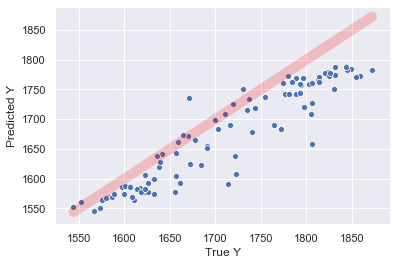

In [36]:
line_x_y = [math.floor(min(y_test.min(),y_hat.min())), math.ceil(max(y_test.max(),y_hat.max()))]
_ = plt.plot(line_x_y, line_x_y, linewidth=10, alpha=0.2, color='red')
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()